In [1]:
import pandas as pd
import optuna
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from catboost import CatBoostRegressor
from tqdm import tqdm
import warnings

In [3]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971244 entries, 0 to 971243
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   lcl_dt                 971244 non-null  object 
 1   item_id                971244 non-null  int64  
 2   avg_price              971244 non-null  float64
 3   city_name              971244 non-null  object 
 4   lvl3_category_name     971244 non-null  object 
 5   lvl4_subcategory_name  968928 non-null  object 
 6   lvl5_subcategory_name  951661 non-null  object 
 7   osa_perc               855367 non-null  float64
 8   sales                  971244 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 66.7+ MB


In [4]:
original_df['lcl_dt'] = pd.to_datetime(original_df['lcl_dt'])

In [5]:
original_df.head()

,lcl_dt,item_id,avg_price,city_name,lvl3_category_name,lvl4_subcategory_name,lvl5_subcategory_name,osa_perc,sales
0,2024-01-26,10000001,92.000000,Новосибирск,Напитки,Безалкогольные напитки,Напитки газированные,0.868421,26.0
1,2024-01-26,10000005,342.157895,Новосибирск,Замороженная продукция,Пельмени и вареники,Пельмени,0.904605,19.0
2,2024-01-26,10000013,159.857143,Новосибирск,Замороженная продукция,Овощи и смеси замороженные,Овощи замороженные,0.983553,7.0
3,2024-01-26,10000014,202.600000,Новосибирск,Замороженная продукция,Пельмени и вареники,Вареники,0.940789,5.0
4,2024-01-26,10000015,83.950000,Москва,Кондитерские изделия и снеки,Шоколад и шоколадные батончики,Шоколад,0.299342,75.0


In [6]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971244 entries, 0 to 971243
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   lcl_dt                 971244 non-null  datetime64[ns]
 1   item_id                971244 non-null  int64         
 2   avg_price              971244 non-null  float64       
 3   city_name              971244 non-null  object        
 4   lvl3_category_name     971244 non-null  object        
 5   lvl4_subcategory_name  968928 non-null  object        
 6   lvl5_subcategory_name  951661 non-null  object        
 7   osa_perc               855367 non-null  float64       
 8   sales                  971244 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 66.7+ MB


## Преобразование данных

In [10]:
# Функция для добавления временных признаков
def add_time_features(df):
    df['day_of_week'] = df['lcl_dt'].dt.dayofweek
    df['week_of_year'] = df['lcl_dt'].dt.isocalendar().week
    df['month_of_year'] = df['lcl_dt'].dt.month
    df['week_of_month'] = df['lcl_dt'].apply(lambda x: (x.day - 1) // 7 + 1)
    return df.copy()

# Объединенная функция для создания лагов и расчета суммы продаж
def create_lagged_sales_sums(df, days):
    df = df.sort_values(by=['city_name', 'item_id', 'lcl_dt'])
    
    # Создание лагов
    for day in range(1, days + 1):
        df[f'sales_lag_{day}'] = df.groupby(['city_name', 'item_id'])['sales'].shift(day)
        df[f'osa_perc_lag_{day}'] = df.groupby(['city_name', 'item_id'])['osa_perc'].shift(day)
        df[f'avg_price_lag_{day}'] = df.groupby(['city_name', 'item_id'])['avg_price'].shift(day)
        df[f'future_price_lag_{day}'] = df.groupby(['city_name', 'item_id'])['avg_price'].shift(-day)
    
    # Расчет целевых переменных
    df['future_sales_sum'] = df.groupby(['city_name', 'item_id'])['sales'].transform(lambda x: x.rolling(window=days, min_periods=1).sum().shift(-days+1))
    df['past_sales_sum'] = df.groupby(['city_name', 'item_id'])['sales'].transform(lambda x: x.rolling(window=days).sum())
    
    return df.copy()

# Определение количества дней для лагов
days = 7

# Добавляем временные признаки
df = add_time_features(original_df)

# Создаем лаги и целевые переменные
df = create_lagged_sales_sums(df, days)

In [11]:
df.head()

,lcl_dt,item_id,avg_price,city_name,lvl3_category_name,lvl4_subcategory_name,lvl5_subcategory_name,osa_perc,sales,day_of_week,...,sales_lag_6,osa_perc_lag_6,avg_price_lag_6,future_price_lag_6,sales_lag_7,osa_perc_lag_7,avg_price_lag_7,future_price_lag_7,future_sales_sum,past_sales_sum
956573,2024-04-24,1021,100.328542,Екатеринбург,Замороженная продукция,Полуфабрикаты из теста замороженные,Блинчики замороженные,0.898174,336.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
956575,2024-04-24,1022,149.036145,Екатеринбург,Замороженная продукция,Полуфабрикаты из теста замороженные,Блинчики замороженные,0.917742,166.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
956579,2024-04-24,1023,599.000000,Екатеринбург,Гигиена,Для бритья,Женское бритье,0.907555,68.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
956584,2024-04-24,1028,148.215311,Екатеринбург,Гигиена,Туалетная бумага и бумажная продукция,Бумажные полотенца,0.925595,418.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
956598,2024-04-24,1038,69.407341,Екатеринбург,Кондитерские изделия и снеки,Вафли,Вафли традиционные,0.911904,613.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.shape

(971244, 43)

In [13]:
df.columns

Index(['lcl_dt', 'item_id', 'avg_price', 'city_name', 'lvl3_category_name',
       'lvl4_subcategory_name', 'lvl5_subcategory_name', 'osa_perc', 'sales',
       'day_of_week', 'week_of_year', 'month_of_year', 'week_of_month',
       'sales_lag_1', 'osa_perc_lag_1', 'avg_price_lag_1',
       'future_price_lag_1', 'sales_lag_2', 'osa_perc_lag_2',
       'avg_price_lag_2', 'future_price_lag_2', 'sales_lag_3',
       'osa_perc_lag_3', 'avg_price_lag_3', 'future_price_lag_3',
       'sales_lag_4', 'osa_perc_lag_4', 'avg_price_lag_4',
       'future_price_lag_4', 'sales_lag_5', 'osa_perc_lag_5',
       'avg_price_lag_5', 'future_price_lag_5', 'sales_lag_6',
       'osa_perc_lag_6', 'avg_price_lag_6', 'future_price_lag_6',
       'sales_lag_7', 'osa_perc_lag_7', 'avg_price_lag_7',
       'future_price_lag_7', 'future_sales_sum', 'past_sales_sum'],
      dtype='object')

In [14]:
# Фильтрация по критерию стабильности цены
def is_price_stable(row, threshold=0.05):
    start_price = row['avg_price']
    if start_price == 0:  # Добавлена проверка на ноль
        return False
    
    for day in range(1, days + 1):
        future_price = row[f'future_price_lag_{day}']
        if abs((future_price - start_price) / start_price) > threshold:
            return False
    return True

# Применение фильтрации
stable_price_df = df[df.apply(is_price_stable, axis=1)]

# Удаляем строки с NaN, созданные при сдвиге
stable_price_df = stable_price_df.dropna(subset=[f'future_price_lag_1', f'future_sales_sum', 'past_sales_sum'])

In [15]:
stable_price_df['target'] = stable_price_df['future_sales_sum']/stable_price_df['past_sales_sum']

In [16]:
stable_price_df.shape

(608806, 44)

In [17]:
stable_price_df.columns

Index(['lcl_dt', 'item_id', 'avg_price', 'city_name', 'lvl3_category_name',
       'lvl4_subcategory_name', 'lvl5_subcategory_name', 'osa_perc', 'sales',
       'day_of_week', 'week_of_year', 'month_of_year', 'week_of_month',
       'sales_lag_1', 'osa_perc_lag_1', 'avg_price_lag_1',
       'future_price_lag_1', 'sales_lag_2', 'osa_perc_lag_2',
       'avg_price_lag_2', 'future_price_lag_2', 'sales_lag_3',
       'osa_perc_lag_3', 'avg_price_lag_3', 'future_price_lag_3',
       'sales_lag_4', 'osa_perc_lag_4', 'avg_price_lag_4',
       'future_price_lag_4', 'sales_lag_5', 'osa_perc_lag_5',
       'avg_price_lag_5', 'future_price_lag_5', 'sales_lag_6',
       'osa_perc_lag_6', 'avg_price_lag_6', 'future_price_lag_6',
       'sales_lag_7', 'osa_perc_lag_7', 'avg_price_lag_7',
       'future_price_lag_7', 'future_sales_sum', 'past_sales_sum', 'target'],
      dtype='object')

In [18]:
data = stable_price_df.copy()

## Заполнение пропусков

In [19]:
data[['lvl3_category_name', 'lvl4_subcategory_name', 'lvl5_subcategory_name', 'city_name']] =\
data[['lvl3_category_name', 'lvl4_subcategory_name', 'lvl5_subcategory_name', 'city_name']].fillna('None')

## Обучение модели

In [20]:
# Выбор признаков и целевой переменной
lag_features = [f'sales_lag_{day}' for day in range(1, days + 1)] \
             + [f'osa_perc_lag_{day}' for day in range(1, days + 1)] \
             + [f'avg_price_lag_{day}' for day in range(1, days + 1)]

categorical_features = ['lvl3_category_name', 'lvl4_subcategory_name', 'lvl5_subcategory_name', 'city_name']
time_features = ['day_of_week', 'week_of_year', 'month_of_year', 'week_of_month']
numerical_features = ['avg_price', 'past_sales_sum']

features = numerical_features + lag_features + categorical_features + time_features
X = data[features]
y = data['target']

# Разделение данных на обучающую и тестовую выборки
train_size = int(len(data) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Disable warnings
warnings.filterwarnings('ignore')

# Загрузка и подготовка данных...

tqdm.pandas()  # For progress bar with Optuna

def objective(trial):
    # Определение гиперпараметров
    iterations = trial.suggest_int('iterations', 0, 300)
    depth = trial.suggest_int('depth', 4, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)

    # Создание модели CatBoost с текущими гиперпараметрами
    catboost_model = CatBoostRegressor(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        loss_function='RMSE',
        cat_features=[features.index(feat) for feat in categorical_features],
        feature_weights=[3.0 if feat == 'avg_price' else 1.0 for feat in features],
        verbose=0
    )
    
    # Обучение модели
    catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)
    
    # Предсказание и расчет метрики
    y_pred = catboost_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    return rmse

# Запуск Optuna с прогресс-баром
study = optuna.create_study(direction='minimize')
for _ in tqdm(range(10), desc="Optimizing"):
    study.optimize(objective, n_trials=1)

# Вывод лучших гиперпараметров
print("Best hyperparameters:", study.best_params)

# Обучение модели с лучшими гиперпараметрами
best_model = CatBoostRegressor(
    iterations=study.best_params['iterations'],
    depth=study.best_params['depth'],
    learning_rate=study.best_params['learning_rate'],
    loss_function='RMSE',
    cat_features=[features.index(feat) for feat in categorical_features],
    feature_weights=[3.0 if feat == 'avg_price' else 1.0 for feat in features],
    verbose=100
)

best_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)

[I 2025-03-17 19:08:26,633] A new study created in memory with name: no-name-4cf9ab9a-493f-42c2-8f4c-263cc2f0027f
Optimizing: 100%|███████████████████████████████| 10/10 [01:04<00:00,  6.48s/it]


Best hyperparameters: {'iterations': 231, 'depth': 5, 'learning_rate': 0.026541441177494934}
0:	learn: 0.9830847	test: 0.3032127	best: 0.3032127 (0)	total: 58.9ms	remaining: 13.5s
100:	learn: 0.9399114	test: 0.2846969	best: 0.2845604 (99)	total: 5.19s	remaining: 6.68s
200:	learn: 0.9099684	test: 0.2805418	best: 0.2804999 (199)	total: 10.1s	remaining: 1.5s
230:	learn: 0.9047650	test: 0.2795924	best: 0.2795924 (230)	total: 11.5s	remaining: 0us

bestTest = 0.2795923787
bestIteration = 230



In [22]:
# Прогнозы
y_pred_catboost = best_model.predict(X_test)
y_pred_catboost = np.clip(y_pred_catboost, 0, None)  # Клиппирование прогнозов до нуля

# Метрики
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
rmse_catboost = np.sqrt(mse_catboost)
mape_catboost = mean_absolute_percentage_error(y_test, y_pred_catboost)

print('CatBoost Regressor MSE:', mse_catboost)
print('CatBoost Regressor RMSE:', rmse_catboost)
print('CatBoost Regressor MAPE:', mape_catboost)

# Важность признаков
feature_importances = best_model.get_feature_importance()
for feature, importance in zip(features, feature_importances):
    print(f'Feature: {feature}, Importance: {importance}')

# Примеры прогнозов
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'CatBoost_Prediction': y_pred_catboost
})

print(comparison_df.head(10))

CatBoost Regressor MSE: 0.07817189831640906
CatBoost Regressor RMSE: 0.27959237885966964
CatBoost Regressor MAPE: 0.18849462287101504
Feature: avg_price, Importance: 15.291823138035468
Feature: past_sales_sum, Importance: 3.6518754810241125
Feature: sales_lag_1, Importance: 7.02393180165986
Feature: sales_lag_2, Importance: 1.5384205993994862
Feature: sales_lag_3, Importance: 1.877726662957644
Feature: sales_lag_4, Importance: 2.0104406812701585
Feature: sales_lag_5, Importance: 1.8030191037323648
Feature: sales_lag_6, Importance: 0.17308026207785138
Feature: sales_lag_7, Importance: 0.4794410324379705
Feature: osa_perc_lag_1, Importance: 28.55763854426192
Feature: osa_perc_lag_2, Importance: 11.617177994678862
Feature: osa_perc_lag_3, Importance: 5.101617826978625
Feature: osa_perc_lag_4, Importance: 2.5790781388223465
Feature: osa_perc_lag_5, Importance: 2.923238950548013
Feature: osa_perc_lag_6, Importance: 2.684539956466282
Feature: osa_perc_lag_7, Importance: 0.051885078979848544


In [23]:
import seaborn as sns

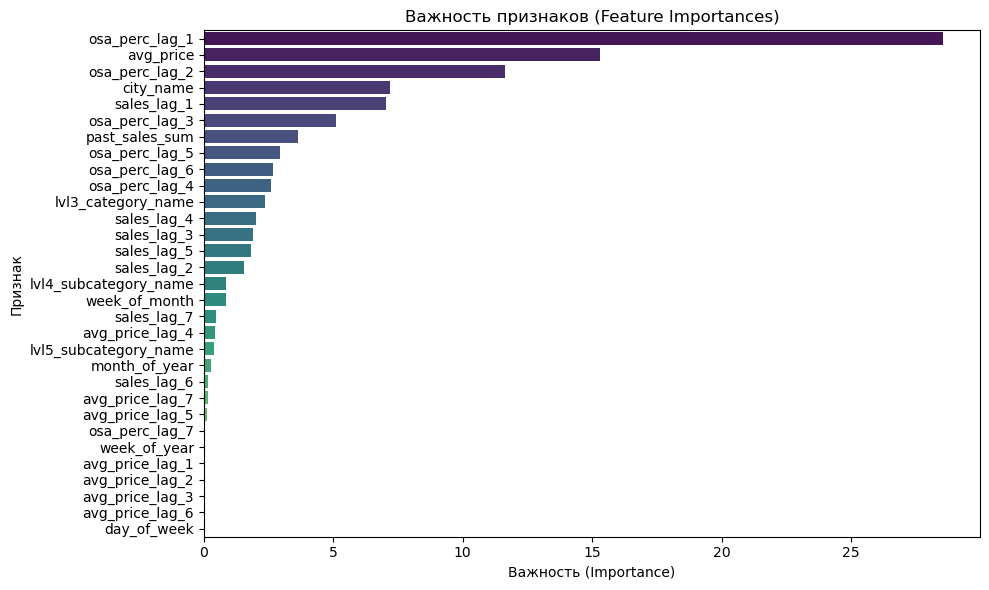

In [24]:
fi_df = pd.DataFrame({
'feature': features,
'importance': feature_importances
})

fi_df.sort_values(by='importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=fi_df, x='importance', y='feature', palette='viridis')

plt.title("Важность признаков (Feature Importances)")
plt.xlabel("Важность (Importance)")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()